<h1><center>Financial Modelling Mid-term Assignment</center></h1>

In [1]:
# Imported all relevant libraries
import warnings
warnings.filterwarnings("ignore")
import wrds
import numpy as np
import pandas as pd
import yfinance as yf
import pyfinra as pf
from math import exp
from pyfinra.ticker import Ticker
from scipy import stats
from pylab import plt
plt.style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

In [2]:
# We will be using 6 years of observations for this financial model
start = '2018-02-01'
end = '2024-02-01'

<h1><center>Observation Period</center></h1>
A six-year observation period is significant because it allows us to capture the company's risk profile and market dynamics over a meaningful period. This timeframe is likely to include a variety of market conditions, such as bullish and bearish phases, which affect both the cost of equity and the cost of debt. It provides a comprehensive view of the company’s performance through different economic environments, leading to a more informed and stable WACC estimation.

<h1><center>Cost of Equity (Re)</center></h1>

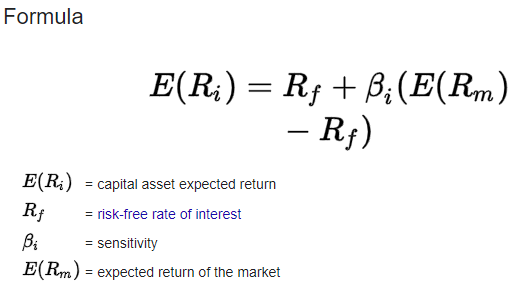

### Definition
The cost of equity is the return that investors expect for investing in a company's equity. It represents the compensation demanded by investors for bearing the risk associated with holding the company's equity securities.

### What Cost of Equity Represents
It reflects the opportunity cost for shareholders, as it is the rate of return they could expect from an investment with a similar risk profile. In financial modeling, it is a critical component as it helps determine the required rate of return for equity investments. This cost influences how much a company should offer to pay its shareholders to justify the risk they are taking. It’s essentially the price the market demands to provide equity capital to the firm, guiding how much value an investment must generate.
<br>
<br>
### CAPM Model Overview
The CAPM model calculates the cost of equity by considering the risk-free rate, which is what investors would expect from an investment with zero risk, and the equity beta, which measures a stock's volatility compared to the overall market. The model also incorporates the expected market return, which is the average return investors expect from the market. By calculating the premium investors require for the extra risk (beta times the market risk premium), the CAPM provides a straightforward way to estimate the return needed to entice investors to fund a company's equity.
<br>
<br>
### Importance of Risk-Free Rate (Rf) in Cost of Equity
In the CAPM formula, the risk-free rate is the foundation for calculating the required return on equity. It represents the minimum return investors would accept, assuming no risk. This rate is crucial because it sets the baseline for assessing additional returns needed to undertake riskier investments. By starting the calculation with the risk-free rate, the CAPM model ensures that any additional returns calculated above this base are purely compensating for the risk associated with the specific equity investment. This component underlines the premise that investors need to be rewarded not only for the time value of money, reflected by the risk-free rate, but also for the additional risk carried over and above a risk-free asset.

### Choice of Risk-Free Rate (Rf)
The U.S 3 month Treasury Bill (TBIL) is selected as the risk-free rate due to its widespread acceptance in financial modeling as a benchmark for risk-free returns. The choice is motivated by the TBIL's short maturity, which minimises interest rate risk, and its backing by the U.S. government, arguably making it free from credit risk. This makes the TBIL an ideal standard for determining the risk-free component in the CAPM model, ensuring that our cost of equity calculation reflects a stable and reliable baseline for comparison.
<br>
<br>
### Importance of Beta (B) in Cost of Equity 
Beta is integral to determining the cost of equity because it adjusts the expected market returns to reflect the specific risk associated with an individual stock. By multiplying the market risk premium (the difference between the expected market return and the risk-free rate) by the stock's Beta, we tailor the premium to the stock's particular risk profile. This calculation acknowledges that riskier stocks (with a Beta greater than 1) should yield higher returns to compensate investors for the increased risk, while less volatile stocks (with a Beta less than 1) yield lower returns. Therefore, Beta allows us to fine-tune the expected return on equity to align with the stock's risk level, ensuring that the CAPM model accurately reflects the risk-return trade-off inherent in equity investments.

### Meaning of Beta (B)
In the context of the CAPM model, Beta serves as a gauge for a stock's relative volatility and risk compared to the broader market. A Beta of 1 indicates that the stock's price is expected to move with the market. A Beta greater than 1 signifies higher volatility than the market, implying that the stock is riskier but may offer higher returns. Conversely, a Beta less than 1 suggests the stock is less volatile and thus less risky compared to the market, but it may also offer lower returns. This metric is crucial for calculating the risk premium, which is the additional return investors require to compensate for the risk of investing in the stock compared to a risk-free investment.
<br>
<br>
### Importance of Expected Market Return (E(Rm)) in Cost of Equity
The expected market return component of the CAPM model captures the average return investors anticipate from the market. This expectation is crucial because it provides a reference point against which the performance of individual stocks can be measured. In the CAPM formula, the difference between the market return and the risk-free rate represents the market risk premium. This premium is the additional return investors demand for choosing to invest in the market with inherent risks, rather than settling for the risk-free rate. The inclusion of the market return in the CAPM model underscores the principle that investors expect to be compensated for both the time value of money and the level of market risk they are exposed to.

### Expected Market Return (E(Rm))
The S&P 500 index is chosen to represent the expected market return because it includes a wide range of companies across various industries, making it a comprehensive reflection of the overall market performance in the United States. Its broad coverage ensures that the market return component of the CAPM model captures the diverse risk and return profiles across the economy, providing a robust basis for estimating the expected return on equity. This choice supports our model's aim to reflect real-world market conditions accurately, ensuring the cost of equity calculation is both relevant and reliable for investment valuation purposes.

In [3]:
# Automation of ticker insertion
tickers = []
x=0
while x < 3:
    ticker = input("Please insert a ticker: ")
    tickers.append(ticker)
    x = x+1

Please insert a ticker: AAPL
Please insert a ticker: MSFT
Please insert a ticker: NVDA


In [5]:
# Function to calculate cost of equity
def cost_of_equity(ticker, start, end):
    # Downloading S&P500 data to calculate Expected Market Returns
    sp500 = yf.download('^GSPC', start=start, end=end).drop(columns=['Open','High','Low','Close','Volume'])
    sp500 = sp500.rename(columns={'Adj Close': 'SP500'})
    
    # Creating new table and storing the calculated log returns of S&P500 inside
    sp500rets = np.log(sp500 / sp500.shift(1))
    
    # Downloading stock ticker data
    stock = yf.download(ticker, start=start, end=end).drop(columns=['Open','High','Low','Close','Volume'])
    stock = stock.rename(columns={'Adj Close': ticker})
    
    # Creating new table and storing the calculated log returns of stock ticker's inside
    stockrets = np.log(stock / stock.shift(1)) 
    
    # Joining the log returns of S&P500 and stock ticker together into one table
    data = sp500.join(stock)
    datarets = sp500rets.join(stockrets)
    datarets = datarets.dropna()
    
    # Downloading US Treasury 3 month bill to calculate Risk-Free rate
    risk_free_rate = yf.download('TBIL', start=start, end=end).drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    risk_free_rate = risk_free_rate.rename(columns={'Adj Close': 'Risk Free Rate'})
    Rf = risk_free_rate.iloc[-1, 0] / 100
    
    # Expected Market Return calculation
    ERm = datarets['SP500'].mean() * 252
    
    # Getting Beta value
    B = np.polyfit(datarets['SP500'], datarets[ticker], deg=1)[0]
    
    # Capital Asset Pricing Model (CAPM) calculation
    CAPM = exp((Rf + ERm - Rf) * B) - 1
    return B, CAPM

# Automating cost of equity results for relevant stock ticker
B = np.array([])
CAPM = np.array([])
for ticker_i in tickers:
    B_i, CAPM_i = cost_of_equity(ticker_i, start, end)
    B = np.append(B, B_i)
    CAPM = np.append(CAPM, CAPM_i)
    print(f"The Beta for {ticker_i} is: {'{:.4}'.format(B_i)}")
    print(f"The Cost of Equity for {ticker_i} is: {'{:.3%}'.format(CAPM_i)}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


The Beta for AAPL is: 1.22
The Cost of Equity for AAPL is: 11.657%


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

The Beta for MSFT is: 1.209
The Cost of Equity for MSFT is: 11.538%
The Beta for NVDA is: 1.752
The Cost of Equity for NVDA is: 17.148%


<h1><center>Cost of Debt (Rd)</center></h1>

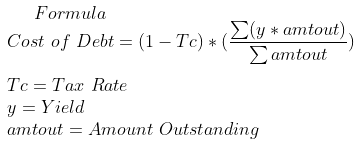

### Definition
The cost of debt is the effective rate that a company pays on its borrowed funds, which includes bank loans, bonds, and other forms of debt. It is expressed as a percentage, representing the annual cost of debt servicing.

### What Cost of Debt Represents 
The cost of debt signifies the average interest rate a company pays on its debt obligations, adjusted for the tax deductibility of interest expenses. This metric is pivotal for corporate finance as it represents one part of a company's capital structure and influences the company's decision on how much debt to use for financing its operations and growth. In financial modeling, the cost of debt is factored into the WACC to assess the company's overall cost of capital, balancing the cheaper cost of debt against the risk of over-leverage.
<br>
<br>
## Tax Rate Calculation for After-Tax Cost of Debt

### Overview of Tax Rate Calculation

The tax rate for the company is determined by analysing the most recent income statement data. We calculate the effective tax rate by dividing the provision for income taxes by the pre-tax income. This rate is then used to adjust the cost of debt, providing a realistic measure of the after-tax burden of debt on the company.
<br>
<br>
## Extraction and Use of WRDS Data for Cost of Debt

### Overview of Bond Data Extraction

To ascertain a company's cost of debt, we extract detailed bond information from the WRDS database, which includes the date of issuance, maturity, amount outstanding, and yield. This dataset is crucial because it contains actual market data, reflecting the real costs companies incur for their debt. The process involves querying WRDS for bonds related to the company's ticker, ensuring the data is fresh and company-specific.

### Weighted Average Yield & Cost of Debt Calculation

We compute the cost of each bond by multiplying its yield by the amount outstanding, then aggregate these figures to find the total weighted yield. This method acknowledges that larger bonds have a more significant impact on the company's finances than smaller ones. The final weighted average yield is obtained by dividing the total weighted yield by the total amount outstanding of all bonds, giving us a precise pre-tax cost of debt for the company. After calculating this, I multiplied the pre-tax cost of debt by the tax rate of the company specific ticker.

In [6]:
# Function to calculate tax rate
def tax_rate_f(ticker):
    global most_recent_income_data, most_recent_balance_data
    # Downloading stock ticker general financial statements
    stock = Ticker(ticker)
    stock_bal = stock.financials_balancesheet()
    stock_inc = stock.financials_inc_statement()
    
    # Downloading stock ticker most recent financial statements to calculate tax rate
    most_recent_quarter = stock_bal.columns[-2]
    most_recent_balance_data = stock_bal[most_recent_quarter].to_frame().droplevel(0, axis=0)
    most_recent_income_data = stock_inc[most_recent_quarter].to_frame().droplevel(0, axis=0)
    
    # Extracting relevant data from financial statements to calculate tax rate
    pretax_income = most_recent_income_data.loc['Pretax Income'].iloc[0]
    tax = -most_recent_income_data.loc['Provision for Income Tax'].iloc[0]
    return [tax/pretax_income, most_recent_quarter, most_recent_balance_data, most_recent_income_data]

# Automating tax rate results for relevant stock ticker
tax_rate = np.array([])
most_recent_quarter = np.array([])
most_recent_balance_data = np.array([])
most_recent_income_data = np.array([])
for ticker_i in tickers:
    tax_rate_i = tax_rate_f(ticker_i)[0]
    most_recent_quarter_i = tax_rate_f(ticker_i)[1]
    most_recent_balance_data_i = tax_rate_f(ticker_i)[2]
    most_recent_income_data_i = tax_rate_f(ticker_i)[3]
    tax_rate = np.append(tax_rate, tax_rate_i)
    most_recent_quarter = np.append(most_recent_quarter, most_recent_quarter_i)
    most_recent_balance_data = np.append(most_recent_balance_data, most_recent_balance_data_i)
    most_recent_income_data = np.append(most_recent_income_data, most_recent_income_data_i)
    print(f"{ticker_i}'s tax rate is: {'{:.3%}'.format(tax_rate_i)}")

AAPL's tax rate is: 14.971%
MSFT's tax rate is: 18.300%
NVDA's tax rate is: 12.155%


In [7]:
# Connecting to the WRDS servers to bring in relevant data
try:
    conn = wrds.Connection()   
except PendingRollbackError:
    wrds.rollback()

# Function to calculate cost of debt
def cost_of_debt(ticker, tax_rate):    
    # Brings in stock ticker Bonds' information as a table
    rows = conn.get_table(library='wrdsapps_bondret',table='bondret', columns = ['date', 'cusip', 'isin', 'company_symbol',
                          'offering_amt', 'amount_outstanding', 'maturity', 'yield'])

    # Extract relevant stock ticker data from the Bond table
    from datetime import date
    today = date.today()
    bondticker = rows[rows["company_symbol"].isin([ticker])]
    bondmat = bondticker[bondticker["maturity"] > today]
    ubonds = bondmat.groupby("isin", as_index=False).last()
    
    # Weighted yield calculation
    ubonds["weighted yield"] = ubonds["yield"] * ubonds["amount_outstanding"]
    
    # Total weight calculation
    total_weight = ubonds["amount_outstanding"].sum()
   
    # Total weighted yield calculation
    total_weighted_yield = ubonds["weighted yield"].sum()
    
    # Weighted average yield (pre-tax cost of debt) calculation
    weighted_average_yield = total_weighted_yield / total_weight
    
    # Cost of Debt formula calculation
    CoD = ((1-tax_rate) * weighted_average_yield)
    
    return CoD

# Automating cost of debt results for relevant stock ticker
CoD = np.array([])
for count, ticker_i in enumerate(tickers):
    CoD_i = cost_of_debt(ticker_i, tax_rate[count])
    CoD = np.append(CoD, CoD_i)
    print(f"The Cost of Debt for {ticker_i} is: {'{:.3%}'.format(CoD_i)}")

Enter your WRDS username [rodri]:ro00257
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done
The Cost of Debt for AAPL is: 3.953%
The Cost of Debt for MSFT is: 3.707%
The Cost of Debt for NVDA is: 4.097%


# Weighted Average Cost of Capital (WACC)
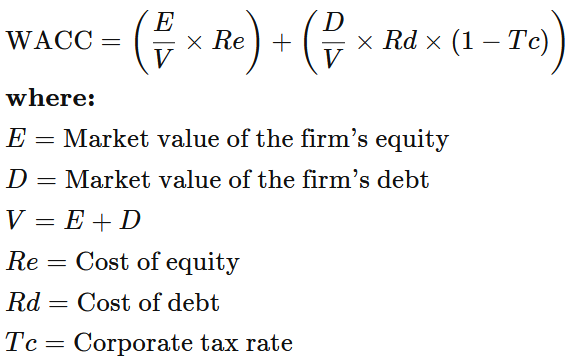

### Definition
WACC is the average rate of return a company is expected to pay to its security holders to finance its assets. It is calculated by weighting the cost of equity and the cost of debt by their respective proportions in the company’s capital structure.

### What WACC Represents 
WACC embodies the average cost a company incurs for funding from both equity and debt sources. It is an essential measure in finance as it reflects the overall cost of capital, considering the different costs and proportions of equity and debt financing. For a company, WACC is the hurdle rate that investments must exceed for them to be considered worthwhile. It’s a critical threshold in decision-making for new projects, acquisitions, and other capital investments. In financial modeling, WACC is used in discounted cash flow (DCF) analysis to discount future cash flows and determine the present value of a company or investment opportunity.
<br>
<br>
## Components of WACC

### Cost of Equity (E/V × Re):

- E/V: This represents the proportion of equity in the company’s total value (E is the market value of the equity, and V is the total value of the company).

- Re: This is the cost of equity as calculated using models like CAPM, which compensates investors for the risk taken above the risk-free rate.

The equity portion of WACC is weighted by the proportion of equity in the firm's total financing (E/V). This reflects the relative significance of equity financing in funding the company's operations and growth. The cost of equity component (Re) considers the returns required by shareholders and is critical in ensuring that the company's equity valuation reflects the risks and growth expectations. It acts as an indicator of the premium over the risk-free rate that the market demands for bearing the volatility and uncertainty of equity investments.

### Cost of Debt (D/V × Rd) × (1 - Tc):

- D/V: This reflects the proportion of debt in the company’s total value (D is the total debt, and V is the total value of the company).

- Rd: This is the cost of debt, indicating the average rate paid on the company's debt.

- (1 - Tc): This factor accounts for the corporate tax rate, recognising the income tax the company in question has to pay for the year.

The debt portion within WACC is weighted by D/V, indicating debt's role in the firm's capital structure. The cost of debt (Rd) is the effective interest rate the company pays on its debt, adjusted to reflect the tax savings from the tax deductibility of interest (expressed as (1 - Tc)). This tax shield reduces the actual burden of debt costs on the firm. By incorporating the after-tax cost of debt, WACC provides a more accurate representation of the cost efficiency of debt financing as part of the company’s broader financing strategy.
<br>
<br>
## Significance of WACC

### Role in Corporate Finance and Valuation:

###     • WACC as a Hurdle Rate
WACC serves as the minimum return a company needs to achieve on its investments to satisfy its shareholders and    creditors. It acts as a benchmark or hurdle rate for evaluating investment decisions, ensuring that only those projects expected to generate a higher return than the WACC are pursued, which theoretically leads to value creation for shareholders.

###     • Use in Discounted Cash Flow Analysis
In valuation models, particularly the Discounted Cash Flow (DCF) analysis, WACC is used as the discount rate to calculate the present value of future cash flows. The choice of WACC reflects the opportunity cost of capital and is pivotal in assessing the viability and profitability of potential projects or investments.

In [8]:
# Function to calculate weigthed average cost of capital (WACC)
def WACC (most_recent_balance_data, most_recent_income_data, tax_rate, CoD, CAPM, ticker):
    # Downloading stock ticker general financial statements
    stock = Ticker(ticker)
    stock_bal = stock.financials_balancesheet()
    stock_inc = stock.financials_inc_statement()
    
    # Downloading stock ticker most recent financial statements to calculate debt and equity
    most_recent_quarter = stock_bal.columns[-2]
    most_recent_balance_data = stock_bal[most_recent_quarter].to_frame().droplevel(0, axis=0)
    most_recent_income_data = stock_inc[most_recent_quarter].to_frame().droplevel(0, axis=0)
    
    # Extracting relevant data from financial statements to calculate debt and equity
    debt = most_recent_balance_data.loc['Total Liabilities'].iloc[0]
    equity = most_recent_balance_data.loc['Total Equity'].iloc[0]
    
    # WACC formula calculation
    wacc = (debt/(debt+equity)*CoD*(1-tax_rate)+equity/(debt+equity)*CAPM)
    return wacc

# Automating WACC results for relevant stock ticker
wacc = np.array([])
for count, ticker_i in enumerate(tickers):
    wacc_i = WACC(most_recent_balance_data[count], most_recent_income_data[count], tax_rate[count], 
                          CoD[count], CAPM[count], ticker_i)
    wacc = np.append(wacc, wacc_i)
    print(f"{ticker_i}'s WACC is {'{:.2%}'.format(wacc_i)}")

AAPL's WACC is 4.82%
MSFT's WACC is 7.24%
NVDA's WACC is 11.92%
